In [ ]:
import py7zr
with py7zr.SevenZipFile('train.tsv.7z', mode='r') as z:
    z.extractall()
    
with py7zr.SevenZipFile('test.tsv.7z', mode='r') as z:
    z.extractall()

In [ ]:
import pandas as pd 

train_file='train.tsv'
csv_table=pd.read_table(train_file,sep='\t')
csv_table.to_csv('train.csv',index=False)

test_file='test.tsv'
csv_table=pd.read_table(test_file,sep='\t')
csv_table.to_csv('test.csv',index=False)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_log_error
from scipy.sparse import hstack

In [2]:
train = pd.read_csv('train.csv')
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
print('Number of data points in train data: ', train.shape[0])
print('Number of features in train data:', train.shape[1])

Number of data points in train data:  1482535
Number of features in train data: 8


In [4]:
test = pd.read_csv('test.csv')
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [5]:
print('Number of data points in test data: ', test.shape[0])
print('Number of features in test data:', test.shape[1])

Number of data points in test data:  693359
Number of features in test data: 7


# Pre-processing data

In [6]:
def handle_missing_inplace(dataset):
    dataset['category_name'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)

In [7]:
handle_missing_inplace(train)

In [8]:
handle_missing_inplace(test)

In [9]:
train = train[train['price']> 0]
print('Number of data points After eliminating price=0.00 :', train.shape[0])

Number of data points After eliminating price=0.00 : 1481661


# EDA

In [12]:
print(train['price'].describe())

count    1.481661e+06
mean     2.675329e+01
std      3.859198e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64


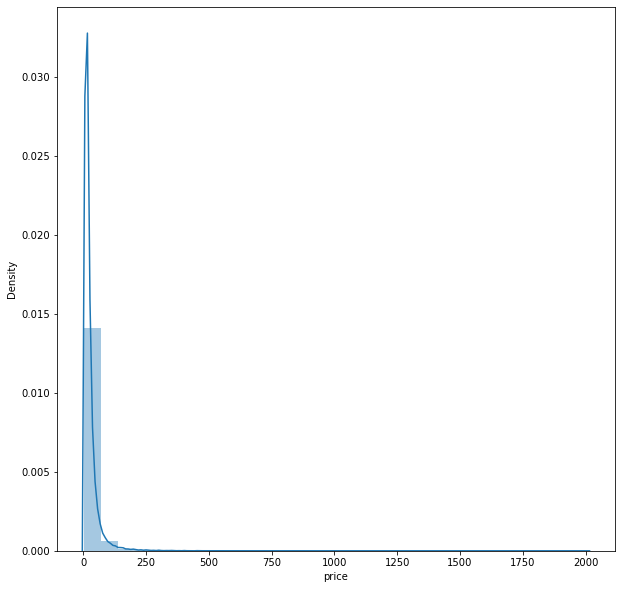

In [13]:
plt.figure(figsize = (10,10))
sns.distplot(train['price'],bins=30)
plt.show()

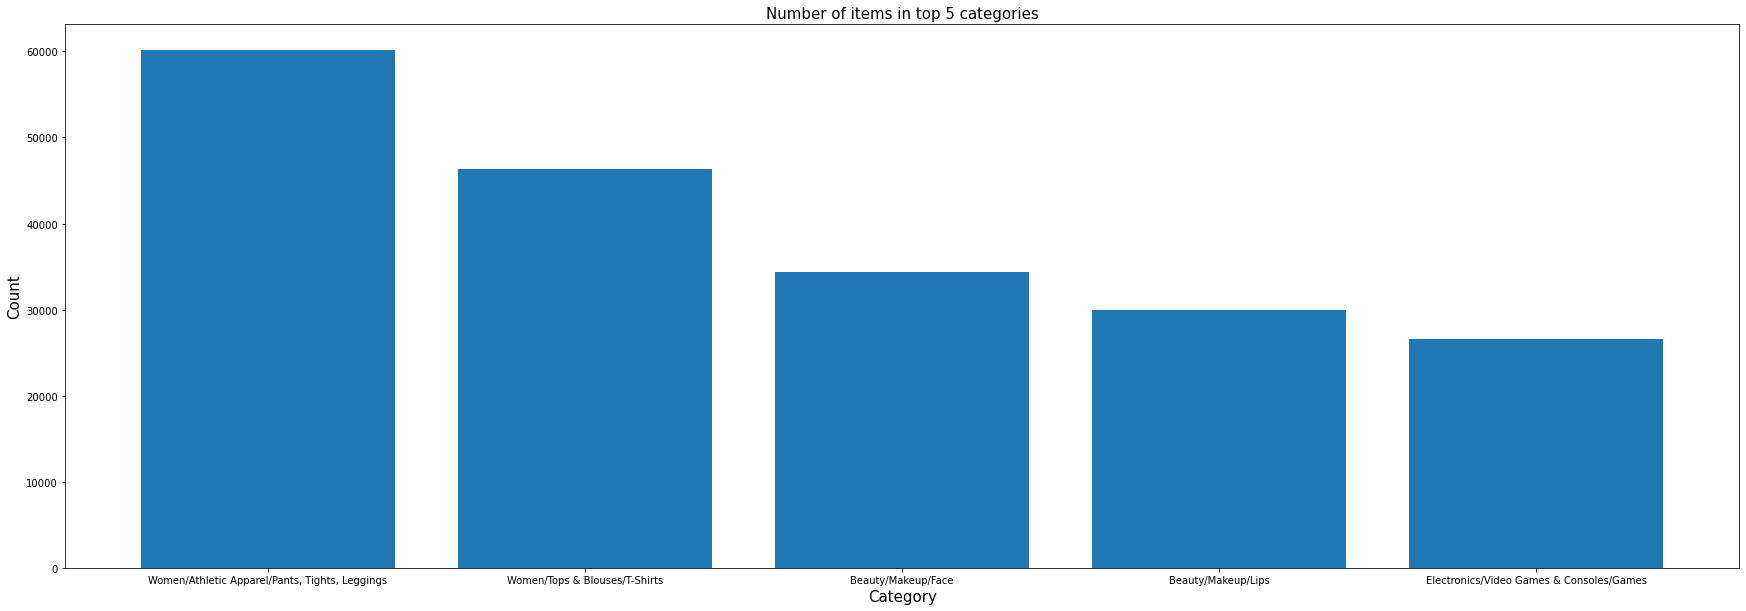

In [14]:
x = train['category_name'].value_counts().index.values.astype('str')[:5]
y = train['category_name'].value_counts().values[:5]
objects = set(train['category_name'])
plt.figure(figsize=(30,10))
plt.bar(x, y, alpha=1, align='center')
plt.ylabel('Count', fontsize=15)
plt.xlabel('Category', fontsize=15)
plt.title('Number of items in top 5 categories', fontsize=15)
plt.show()

In [15]:
unique_categories = train['category_name'].value_counts()
print('Number of Unique categories :', unique_categories.shape[0])

Number of Unique categories : 1288


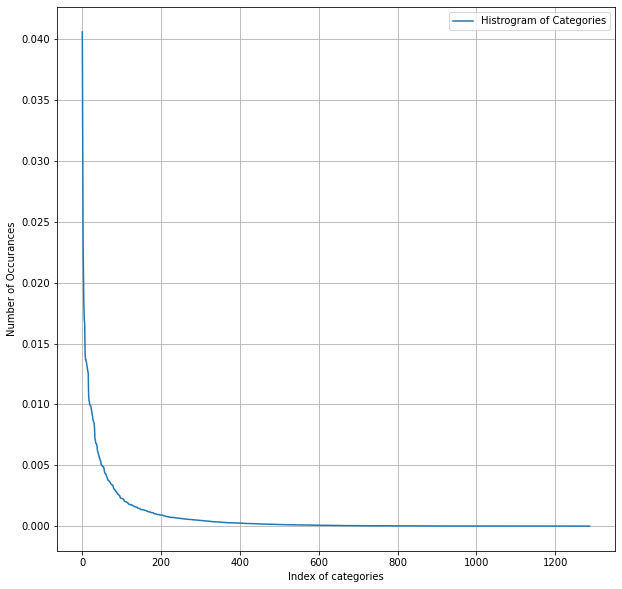

In [16]:
plt.figure(figsize = (10,10))
s = sum(unique_categories.values);
h = unique_categories.values/s;
plt.plot(h, label="Histrogram of Categories")
plt.xlabel('Index of categories')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

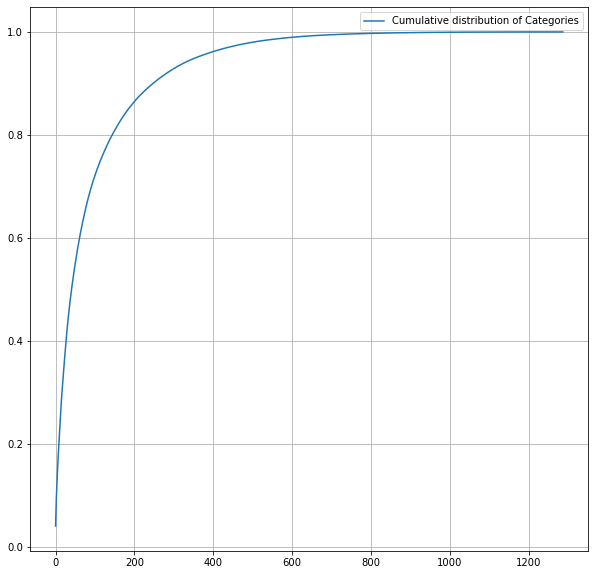

In [17]:
plt.figure(figsize = (10,10))
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Categories')
plt.grid()
plt.legend()
plt.show()

In [18]:
print(train['category_name'].value_counts())

Women/Athletic Apparel/Pants, Tights, Leggings    60152
Women/Tops & Blouses/T-Shirts                     46349
Beauty/Makeup/Face                                34320
Beauty/Makeup/Lips                                29901
Electronics/Video Games & Consoles/Games          26547
                                                  ...  
Handmade/Quilts/Trim                                  1
Handmade/Housewares/Storage Solutions                 1
Handmade/Accessories/Cozy                             1
Home/Home Décor/Doorstops                             1
Handmade/Geekery/Videogame                            1
Name: category_name, Length: 1288, dtype: int64


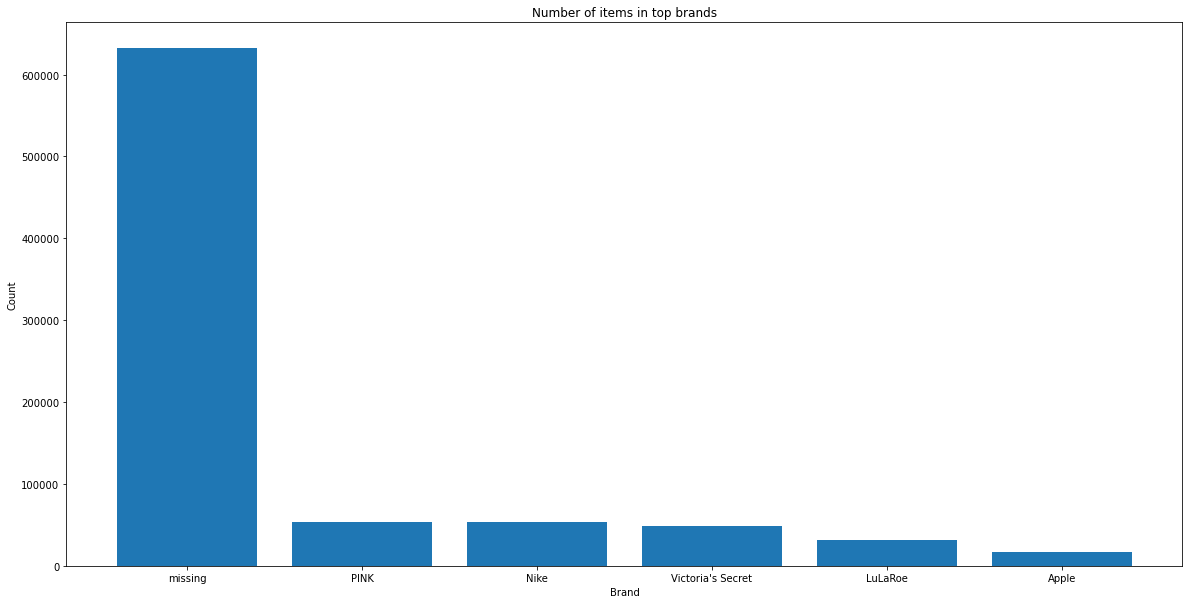

In [19]:
x = train['brand_name'].value_counts().index.values.astype('str')[:6]
y = train['brand_name'].value_counts().values[:6]
objects = set(train['brand_name'])
plt.figure(figsize=(20,10))
plt.bar(x, y, alpha=1, align='center')
plt.ylabel('Count')
plt.xlabel('Brand')
plt.title('Number of items in top brands')
plt.show()

In [20]:
train['brand_name'].value_counts()

missing              632336
PINK                  54072
Nike                  54006
Victoria's Secret     48011
LuLaRoe               30995
                      ...  
Kiton                     1
White Diamond             1
Excell                    1
Brioni                    1
Tria                      1
Name: brand_name, Length: 4808, dtype: int64

In [21]:
unique_brands = train['brand_name'].value_counts()
print('Number of Unique brands :', unique_brands.shape[0])

Number of Unique brands : 4808


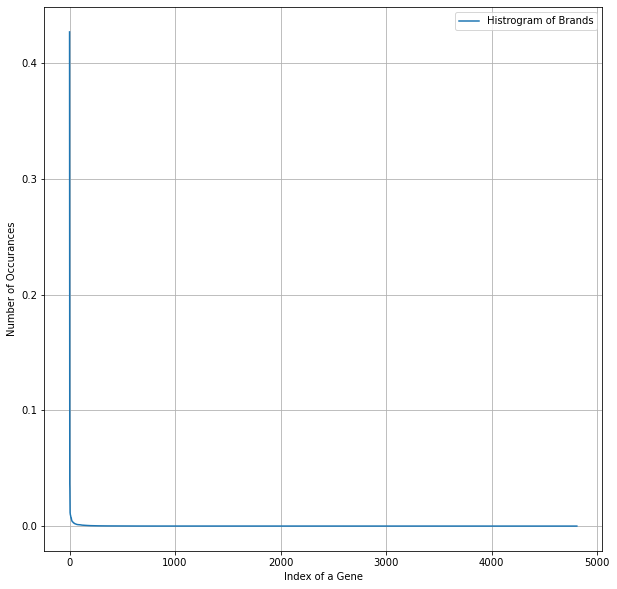

In [22]:
plt.figure(figsize = (10,10))
s = sum(unique_brands.values);
h = unique_brands.values/s;
plt.plot(h, label="Histrogram of Brands")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

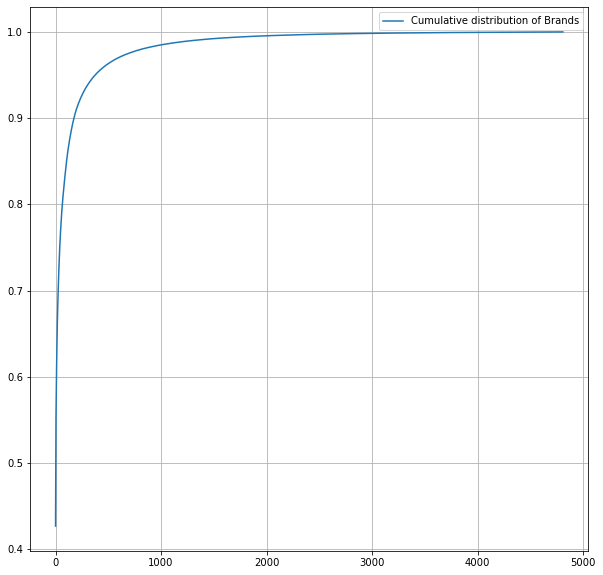

In [23]:
plt.figure(figsize = (10,10))
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Brands')
plt.grid()
plt.legend()
plt.show()

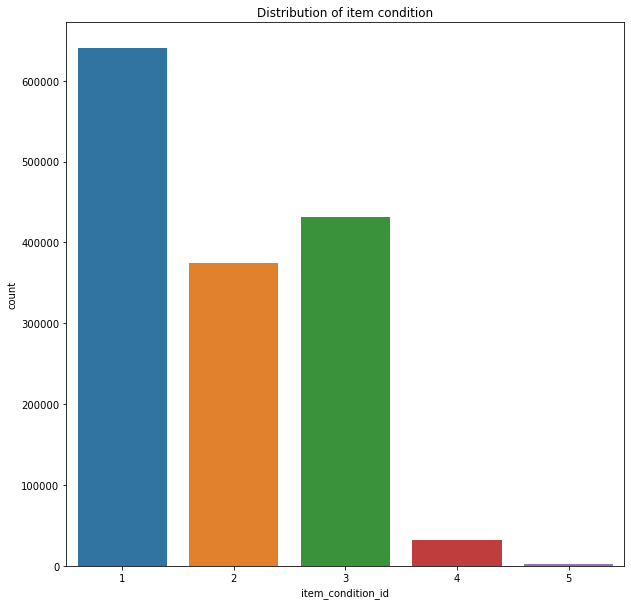

In [24]:
fig, ax = plt.subplots(figsize = (10,10))
plt.title('Distribution of item condition')
sns.countplot(train.item_condition_id)
ax.set_ylabel('count')
plt.show()

In [25]:
train['item_condition_id'].value_counts()

1    640246
3    431892
2    375196
4     31945
5      2382
Name: item_condition_id, dtype: int64

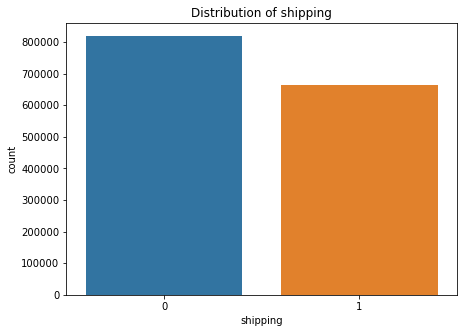

In [26]:
fig, ax = plt.subplots(figsize = (7,5))
plt.title('Distribution of shipping')
sns.countplot(train.shipping)
ax.set_ylabel('count')
plt.show()

In [27]:
train['shipping'].value_counts()

0    818876
1    662785
Name: shipping, dtype: int64

# Feature engineering

In [10]:
def wordCount(text):
    try:
        if text == 'No description yet':
            return 0
        else:
            text = text.lower()
            words = [w for w in text.split(" ")]
            return len(words)
    except: 
        return 0

In [11]:
train['description_len'] = train['item_description'].apply(lambda x: wordCount(x))
test['description_len'] = test['item_description'].apply(lambda x: wordCount(x))
train['name_len'] = train['name'].apply(lambda x: wordCount(x))
test['name_len'] = test['name'].apply(lambda x: wordCount(x))

In [12]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,description_len,name_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet,0,7
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,36,4
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,29,2
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,32,3
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,5,4


# Text pre-processing - ML

In [31]:
print(train.shape)
print(test.shape)
targets = train['price'].values

(1481661, 10)
(693359, 9)


In [32]:
data = pd.concat([train,test])
data.shape

(2175020, 11)

In [33]:
data.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,description_len,name_len,test_id
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet,0,7,NaN
1,1.0,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,36,4,NaN


In [34]:
data.tail(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,description_len,name_len,test_id
693357,NaN,Hi low floral kimono,2,Women/Swimwear/Cover-Ups,missing,NaN,0,Floral kimono. Tropical print. Open front. Hi ...,17,4,693357.0
693358,NaN,"FREESHIP 2 Floral Scrub Tops, medium.",2,Women/Tops & Blouses/T-Shirts,missing,NaN,1,2 Floral scrub tops. Worn less than 5 times ea...,15,6,693358.0


In [35]:
default_preprocessor = CountVectorizer().build_preprocessor()
def build_preprocessor(field):
    field = list(data.columns).index(field)
    return lambda x: default_preprocessor(x[field])

In [36]:
from sklearn.pipeline import FeatureUnion
vectorizer = FeatureUnion([('name', CountVectorizer(max_features=15000,preprocessor=build_preprocessor('name'))),
                           ('category_name', CountVectorizer(token_pattern='.+',preprocessor=build_preprocessor('category_name'))),
                           ('brand_name', CountVectorizer(token_pattern='.+',preprocessor=build_preprocessor('brand_name'))),
                           ('item_description', TfidfVectorizer(ngram_range=(1, 2), max_features=30000,preprocessor=build_preprocessor('item_description')))])
data_ML = vectorizer.fit_transform(data.values)

In [37]:
train_ml = data_ML[:1481661]
test_ml = data_ML[1481661:]
print(train_ml.shape)
print(test_ml.shape)

(1481661, 51599)
(693359, 51599)


# Text pre-processing - DL

In [13]:
train_dl = train
test_dl = test

In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
train_dl_text = np.hstack([train_dl.item_description.str.lower(), train_dl.name.str.lower(), train_dl.category_name.str.lower()])
test_dl_text = np.hstack([test_dl.item_description.str.lower(), test_dl.name.str.lower(), test_dl.category_name.str.lower()])
tok_raw = Tokenizer()
tok_raw.fit_on_texts(train_dl_text)
tok_raw.fit_on_texts(test_dl_text)
train_dl['seq_item_description'] = tok_raw.texts_to_sequences(train_dl.item_description.str.lower())
train_dl['seq_name'] = tok_raw.texts_to_sequences(train_dl.name.str.lower())
train_dl['seq_category'] = tok_raw.texts_to_sequences(train_dl.category_name.str.lower())
test_dl['seq_item_description'] = tok_raw.texts_to_sequences(test_dl.item_description.str.lower())
test_dl['seq_name'] = tok_raw.texts_to_sequences(test_dl.name.str.lower())
test_dl['seq_category'] = tok_raw.texts_to_sequences(test_dl.category_name.str.lower()) 

Using TensorFlow backend.


In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_dl.category_name)
train_dl.category_name = le.transform(train_dl.category_name)
le.fit(train_dl.brand_name)
train_dl.brand_name = le.transform(train_dl.brand_name)
le.fit(test_dl.category_name)
test_dl.category_name = le.transform(test_dl.category_name)
le.fit(test_dl.brand_name)
test_dl.brand_name = le.transform(test_dl.brand_name)

In [16]:
train_dl.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,description_len,name_len,seq_item_description,seq_name,seq_category
0,0,MLB Cincinnati Reds T Shirt Size XL,3,808,4784,10.0,1,No description yet,0,7,"[13, 88, 102]","[2495, 9076, 7078, 71, 101, 7, 199]","[77, 41, 71, 72]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3555,52.0,0,This keyboard is in great condition and works ...,36,4,"[33, 2787, 11, 8, 49, 18, 1, 257, 65, 21, 1206...","[11483, 27977, 17417, 2787]","[62, 921, 831, 3276, 1371]"


# Machine Learning

In [42]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_ml, targets, test_size=0.3)

In [43]:
x_test = test_ml

In [44]:
y_train = np.log1p(y_train)
y_train = y_train.reshape(-1, 1)
y_val = np.log1p(y_val)
y_val = y_val.reshape(-1, 1)

In [30]:
def rmsle(Y_true, Y_pred):
    assert Y_true.shape == Y_pred.shape
    return np.sqrt(np.mean(np.square(Y_pred - Y_true)))

# Linear Regression

In [46]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True, n_jobs=-1)
lr.fit(x_train, y_train)
lr_train_preds = lr.predict(x_train)
print("RMSL error =", rmsle(y_train, lr_train_preds))

RMSL error = 0.4515424348486123


In [47]:
lr.fit(x_train, y_train)
lr_val_preds = lr.predict(x_val)
print("RMSL error =", rmsle(y_val, lr_val_preds))

RMSL error = 0.47612970993341397


In [48]:
lr_test_preds = lr.predict(x_test)
lr_test_preds = np.exp(lr_test_preds)-1

In [49]:
print(lr_test_preds)

[[ 9.39675142]
 [ 9.84121321]
 [57.56383995]
 ...
 [ 6.00166532]
 [12.13996432]
 [13.98278475]]


# Ridge Regression

In [50]:
from sklearn.linear_model import Ridge
r = Ridge(solver='auto', fit_intercept=True, alpha=1,
          max_iter=100, normalize=False,
          tol=0.05, random_state = 1)
r.fit(x_train, y_train)
r_train_preds = r.predict(x_train)
print("RMSL error =", rmsle(y_train, r_train_preds))

RMSL error = 0.4898885894870898


In [51]:
r.fit(x_train, y_train)
r_train_preds = r.predict(x_val)
print("RMSL error =", rmsle(y_val, r_train_preds))

RMSL error = 0.4944317972241432


In [52]:
r_test_preds = r.predict(x_test)
r_test_preds = np.exp(r_test_preds)-1

In [53]:
print(r_test_preds)

[[ 8.83556615]
 [14.26932048]
 [44.52497794]
 ...
 [ 5.25476045]
 [14.61508296]
 [12.50000347]]


# Deep Learning

In [17]:
train_dl.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,description_len,name_len,seq_item_description,seq_name,seq_category
0,0,MLB Cincinnati Reds T Shirt Size XL,3,808,4784,10.0,1,No description yet,0,7,"[13, 88, 102]","[2495, 9076, 7078, 71, 101, 7, 199]","[77, 41, 71, 72]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3555,52.0,0,This keyboard is in great condition and works ...,36,4,"[33, 2787, 11, 8, 49, 18, 1, 257, 65, 21, 1206...","[11483, 27977, 17417, 2787]","[62, 921, 831, 3276, 1371]"
2,2,AVA-VIV Blouse,1,1254,4178,10.0,1,Adorable top with a hint of lace and a key hol...,29,2,"[695, 74, 10, 5, 5464, 12, 243, 1, 5, 1011, 14...","[7910, 10940, 276]","[2, 41, 75, 276]"
3,3,Leather Horse Statues,1,485,4784,35.0,1,New with tags. Leather horses. Retail for [rm]...,32,3,"[6, 10, 80, 229, 6719, 285, 4, 22, 211, 1193, ...","[229, 2720, 623]","[37, 37, 197, 37, 197, 502]"
4,4,24K GOLD plated rose,1,1181,4784,44.0,0,Complete with certificate of authenticity,5,4,"[908, 10, 7123, 12, 2121]","[5072, 127, 1144, 340]","[2, 106, 352]"


In [18]:
from keras.preprocessing.sequence import pad_sequences

MAX_NAME_SEQ = 50
MAX_ITEM_DESC_SEQ = 200
MAX_CATEGORY_SEQ = 10
MAX_TEXT = np.max([np.max(train_dl.seq_name.max()),np.max(train_dl.seq_item_description.max()),
                   np.max(train_dl.seq_category.max())]) + 100
MAX_CATEGORY = np.max(train_dl.category_name.max()) + 1
MAX_BRAND = np.max(train_dl.brand_name.max()) + 1
MAX_CONDITION = np.max(train_dl['item_condition_id'].max()) + 1

def Keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ),
        'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ),
        'category_seq': pad_sequences(dataset.seq_category, maxlen=MAX_CATEGORY_SEQ),
        'brand_name': np.array(dataset.brand_name),
        'category_name': np.array(dataset.category_name),
        'item_condition': np.array(dataset.item_condition_id),
        'num_vars': np.array(dataset[["shipping"]]),
        'description_len': np.array(dataset[["description_len"]]),
        'name_len': np.array(dataset[["name_len"]])
    }
    return X

In [19]:
from sklearn.model_selection import train_test_split
targets = train_dl['price'].values
x_train, x_val, y_train, y_val = train_test_split(train_dl, targets, test_size=0.3)

In [20]:
x_test = test_dl

In [21]:
x_train = Keras_data(x_train)
x_val = Keras_data(x_val)
x_test = Keras_data(x_test)

In [22]:
y_train = np.log1p(y_train)
y_train = y_train.reshape(-1, 1)
y_val = np.log1p(y_val)
y_val = y_val.reshape(-1, 1)

# LSTM - 2 Layers

In [25]:
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, LSTM
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

np.random.seed(54)
def LSTM_model():
    name = Input(shape=[x_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[x_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[1], name="num_vars")
    description_len = Input(shape=[1], name="description_len")
    name_len = Input(shape=[1], name="name_len")
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_TEXT, 20)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    emb_shipping = Embedding(2, 5)(num_vars)
    rnn_layer1 = LSTM(32, dropout=0.6)(emb_item_desc)
    rnn_layer2 = LSTM(16, dropout=0.6)(emb_name)
    main_l = concatenate([
        Flatten()(emb_category_name),
        Flatten()(emb_brand_name),
        Flatten() (emb_shipping),
        Flatten()(emb_item_condition),
        num_vars,
        rnn_layer1,
        rnn_layer2,
        description_len,
        name_len])
    main_l = Dropout(0.1)(Dense(512, activation='relu')(main_l))
    main_l = Dropout(0.1)(Dense(256, activation='relu')(main_l))
    output = Dense(1, activation="relu")(main_l)
    model = Model([name, item_desc, brand_name, category_name, item_condition, num_vars, description_len, name_len], output)
    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss="mse", optimizer= optimizer)
    return model

In [61]:
model = LSTM_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
category_name (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
brand_name (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
num_vars (InputLayer)           [(None, 1)]          0                                            
_____________________________________________________________________________________________

In [62]:
model_1 = model.fit(x_train, y_train,epochs=3,batch_size=2000,validation_data=(x_val, y_val),verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1037162 samples, validate on 444499 samples
Epoch 1/3
1037162/1037162 [==============================] - 1665s 2ms/sample - loss: 0.8233 - val_loss: 0.2422
Epoch 2/3
1037162/1037162 [==============================] - 1668s 2ms/sample - loss: 0.2474 - val_loss: 0.2415
Epoch 3/3
1037162/1037162 [==============================] - 1651s 2ms/sample - loss: 0.2206 - val_loss: 0.2172


In [63]:
pred = model.predict(x_val, batch_size=2000)
print("RMSLE error:", rmsle(y_val, pred))

RMSLE error: 0.4660529643792524


In [32]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

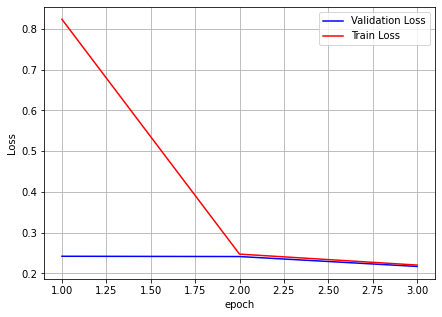

In [67]:
fig,ax = plt.subplots(1,1, figsize = (7,5))
ax.set_xlabel('epoch')
ax.set_ylabel('Loss') 
x = list(range(1,4)) 
vy = model_1.history['val_loss']
ty = model_1.history['loss']
plt_dynamic(x, vy, ty, ax)

# LSTM 3-Layers

In [26]:
np.random.seed(54)
def LSTM_model():
    name = Input(shape=[x_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[x_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[1], name="num_vars")
    description_len = Input(shape=[1], name="description_len")
    name_len = Input(shape=[1], name="name_len")
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_TEXT, 20)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    emb_shipping = Embedding(2, 5)(num_vars)
    rnn_layer1 = LSTM(32, dropout=0.6)(emb_item_desc)
    rnn_layer2 = LSTM(16, dropout=0.6)(emb_name)
    rnn_layer3 = LSTM(8, dropout=0.6) (emb_category_name)
    main_l = concatenate([
        Flatten()(emb_brand_name),
        Flatten() (emb_shipping),
        Flatten()(emb_item_condition),
        num_vars,
        rnn_layer1,
        rnn_layer2,
        rnn_layer3,
        description_len,
        name_len])
    main_l = Dropout(0.1)(Dense(512, activation='relu')(main_l))
    main_l = Dropout(0.1)(Dense(256, activation='relu')(main_l))
    output = Dense(1, activation="relu")(main_l)
    model = Model([name, item_desc, brand_name, category_name, item_condition, num_vars, description_len, name_len], output)
    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss="mse", optimizer= optimizer)
    return model

In [27]:
model = LSTM_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
num_vars (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_condition (InputLayer)     [(None, 1)]          0                                            
_____________________________________________________________________________________________

In [28]:
model_2 = model.fit(x_train, y_train,epochs=3,batch_size=2000,validation_data=(x_val, y_val),verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1037162 samples, validate on 444499 samples
Epoch 1/3
1037162/1037162 [==============================] - 1686s 2ms/sample - loss: 0.6275 - val_loss: 0.2846
Epoch 2/3
1037162/1037162 [==============================] - 1679s 2ms/sample - loss: 0.2465 - val_loss: 0.2392
Epoch 3/3
1037162/1037162 [==============================] - 1656s 2ms/sample - loss: 0.2213 - val_loss: 0.2328


In [31]:
pred = model.predict(x_val, batch_size=2000)
print("RMSLE error:", rmsle(y_val, pred))

RMSLE error: 0.48247702101607715


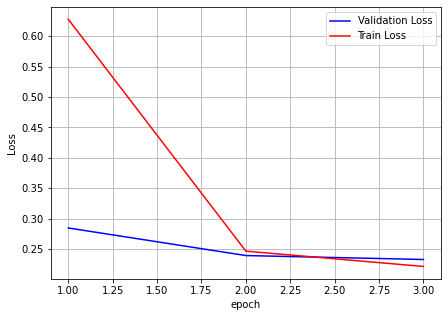

In [33]:
fig,ax = plt.subplots(1,1, figsize = (7,5))
ax.set_xlabel('epoch')
ax.set_ylabel('Loss') 
x = list(range(1,4)) 
vy = model_2.history['val_loss']
ty = model_2.history['loss']
plt_dynamic(x, vy, ty, ax)